In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
import time
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

Data on reviewed restaurants in Illinois was extracted from the yelp data set, wrangled in the [ylp_recommends_us](ylp_recommends_us.ipynb) jupyter notebook and saved as `restaurants_all_info.csv`

The file `restaurants_all_info.csv` contains data extracted from four different files that make up the yelp data set. It was obtained by merging these files on specific business ids that were found to be ids of eateries or restaurants in Illinois. The file is loaded, wrangled and analyzed further below.

In [74]:
# Read file containing details of restaurants in IL
restaurant_revsratscmntz = pd.read_csv('restaurants_all_info_IL.csv')

In [75]:
restaurant_revsratscmntz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26977 entries, 0 to 26976
Data columns (total 16 columns):
Unnamed: 0             26977 non-null int64
review_id              26977 non-null object
user_id                26977 non-null object
business_id            26977 non-null object
user_restau_rating     26977 non-null int64
text                   26977 non-null object
user_name              26958 non-null object
user_review_count      26977 non-null int64
user_avg_stars         26977 non-null float64
restau_name            26977 non-null object
city                   26977 non-null object
state                  26977 non-null object
postal_code            26940 non-null float64
restau_rating          26977 non-null float64
restau_review_count    26977 non-null int64
categories             26977 non-null object
dtypes: float64(3), int64(4), object(9)
memory usage: 3.3+ MB



#### Numerical and Visual Exploratory Data Analysis

Pandas methods like `.info()`, `.head()` and `.describe()` are used in numerical EDA. Matplotlib and seaborn are used in plotting different pandas `groupby` aggregations of the data for Visual EDA.


 

In [76]:
# checking to see that all rating values are between 1 & 5 and type int.

print(type(restaurant_revsratscmntz.user_restau_rating.unique()[0]))
restaurant_revsratscmntz.user_restau_rating.unique()

<class 'numpy.int64'>


array([4, 2, 5, 1, 3])

In [77]:
# Drop unnamed column which is a column of indices imported with the loaded file 
restaurant_revsratscmntz.drop('Unnamed: 0', axis=1,inplace=True, errors='ignore')

The `postal_code` column count indicates missing values as shown below. The missing codes are tied to two restaurants *`"ROKs Tacos - Korean BBQ Tacos"`* and *`"Dragon Fire Pizza"`*

In [78]:
# Show rows where the postal_code is null
restaurant_revsratscmntz[restaurant_revsratscmntz.postal_code.isnull()].count()


review_id              37
user_id                37
business_id            37
user_restau_rating     37
text                   37
user_name              37
user_review_count      37
user_avg_stars         37
restau_name            37
city                   37
state                  37
postal_code             0
restau_rating          37
restau_review_count    37
categories             37
dtype: int64

In [79]:
# create an array of restaurants which do not have a postal_code.
restaus_woutpcodes = restaurant_revsratscmntz.restau_name[restaurant_revsratscmntz.postal_code.isnull()].unique()
restaus_woutpcodes

array(['"ROKs Tacos - Korean BBQ Tacos"', '"Dragon Fire Pizza"'],
      dtype=object)



From the null postal_code table above, all the nulls occur for 2 restaurants in Champaign IL. We check the `postal_code` column for the city of Champaign and realize it has four postal codes and a `Nan` code. We do a count of the total number of restaurant reviews by postal code.





In [80]:
# Checking all the postal codes for Champaign

print(restaurant_revsratscmntz.postal_code[restaurant_revsratscmntz.city=='Champaign'].unique())
restaurant_revsratscmntz[restaurant_revsratscmntz.city == 'Champaign'].groupby('postal_code')['user_restau_rating','city'].count()

[61821. 61820. 61822. 61801.    nan]


,user_restau_rating,city
postal_code,,
61801.0,59,59
61820.0,15486,15486
61821.0,2141,2141
61822.0,1959,1959



Checking with Google shows that the `postal_code` for the two restaurants in Champaign IL is `61801` with which we fill the missing codes in the table.


In [81]:
# where there is a null postal code for the city of Champaign fill it with 61801

restaurant_revsratscmntz.postal_code[(restaurant_revsratscmntz.postal_code.isnull())&(restaurant_revsratscmntz.city=='Champaign')] = 61801


Checking the postal_codes again reveals no `Nan` codes and increases the count of the number of reviews per postal code from `59` to `96`

In [82]:
# Verifying the postal code count. We see an addition of 37 61801 postal codes.

print(restaurant_revsratscmntz.postal_code[restaurant_revsratscmntz.city=='Champaign'].unique())
restaurant_revsratscmntz[restaurant_revsratscmntz.city == 'Champaign'].groupby('postal_code')['user_restau_rating','city'].count()

[61821. 61820. 61822. 61801.]


,user_restau_rating,city
postal_code,,
61801.0,96,96
61820.0,15486,15486
61821.0,2141,2141
61822.0,1959,1959


In [83]:
# We see that postal code has the same number of entries as city.
restaurant_revsratscmntz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26977 entries, 0 to 26976
Data columns (total 15 columns):
review_id              26977 non-null object
user_id                26977 non-null object
business_id            26977 non-null object
user_restau_rating     26977 non-null int64
text                   26977 non-null object
user_name              26958 non-null object
user_review_count      26977 non-null int64
user_avg_stars         26977 non-null float64
restau_name            26977 non-null object
city                   26977 non-null object
state                  26977 non-null object
postal_code            26977 non-null float64
restau_rating          26977 non-null float64
restau_review_count    26977 non-null int64
categories             26977 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 3.1+ MB


In [84]:
# Checking for any duplicates
restaurant_revsratscmntz = restaurant_revsratscmntz.drop_duplicates()
restaurant_revsratscmntz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26977 entries, 0 to 26976
Data columns (total 15 columns):
review_id              26977 non-null object
user_id                26977 non-null object
business_id            26977 non-null object
user_restau_rating     26977 non-null int64
text                   26977 non-null object
user_name              26958 non-null object
user_review_count      26977 non-null int64
user_avg_stars         26977 non-null float64
restau_name            26977 non-null object
city                   26977 non-null object
state                  26977 non-null object
postal_code            26977 non-null float64
restau_rating          26977 non-null float64
restau_review_count    26977 non-null int64
categories             26977 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 3.3+ MB


In [85]:
# choosing relevant columns.

restaurants_revsratscmntz = restaurant_revsratscmntz[['user_id', 'business_id',
       'user_restau_rating', 'text', 'user_name', 'user_review_count',
       'user_avg_stars', 'restau_name', 'city','postal_code', 'state', 'restau_rating',
       'restau_review_count', 'categories']]

#### Ratings Popularity:



In [86]:
sns.set_style('darkgrid',{'patch.edgecolor':'None'})

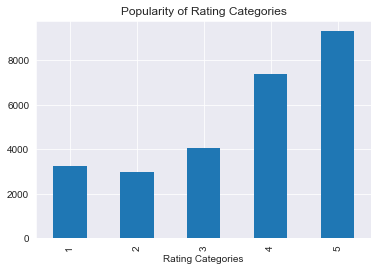

In [87]:
restaurant_revsratscmntz.groupby('user_restau_rating')['business_id'].count().plot(kind='bar')
plt.title('Popularity of Rating Categories')
plt.xlabel('Rating Categories')
plt.show()

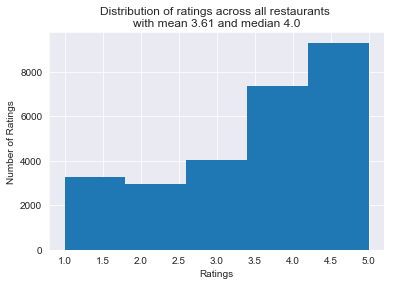

4.0


count    26977.000000
mean         3.612781
std          1.368265
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: user_restau_rating, dtype: float64

In [88]:

plt.hist(restaurant_revsratscmntz.user_restau_rating, bins=5)
plt.title(f'Distribution of ratings across all restaurants \nwith mean {np.round(restaurant_revsratscmntz.user_restau_rating.mean(),2)} and median {restaurant_revsratscmntz.user_restau_rating.median()}')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

print(restaurant_revsratscmntz.user_restau_rating.median())
restaurant_revsratscmntz.user_restau_rating.describe()

From the ratings and distribution plots below, it indicates that the most popular rating is `5 stars` while the least popular is `2 stars`. This indicates a potential of reviewers to give a `1 star` instead of a `2 star` rating when they thought a restaurant was particularly subpar.

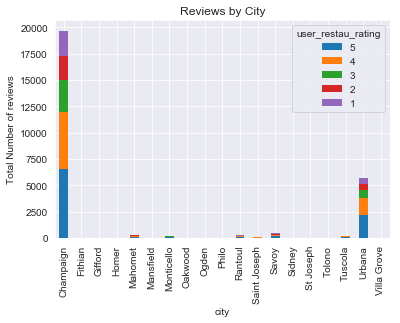

user_restau_rating,5,4,3,2,1
city,,,,,
Champaign,6580.0,5358.0,3112.0,2209.0,2423.0
Fithian,2.0,2.0,NaN,NaN,NaN
Gifford,1.0,6.0,1.0,1.0,2.0
Homer,14.0,4.0,1.0,NaN,NaN
Mahomet,127.0,60.0,41.0,37.0,37.0
Mansfield,5.0,2.0,NaN,NaN,NaN
Monticello,74.0,51.0,27.0,17.0,20.0
Oakwood,4.0,2.0,1.0,NaN,4.0
Ogden,2.0,3.0,1.0,4.0,4.0


In [89]:
ratings_by_city = restaurant_revsratscmntz.groupby(['city','user_restau_rating'])['user_restau_rating'].count().unstack('user_restau_rating').sort_values('user_restau_rating', axis=1, ascending=False)
ratings_by_city.plot(title = 'Reviews by City',kind='bar',stacked=True)
plt.ylabel('Total Number of reviews')
plt.show()
ratings_by_city

The cities of Champaign and Urbana have the highest number of reviews. This might imply these cities have the highest number of restaurants or the restaurants with the highest amount of traffic are located within their zipcodes. The plot below, indicates the Champaign alone has more restaurants than all the other cities combined. Followed by Urbana.

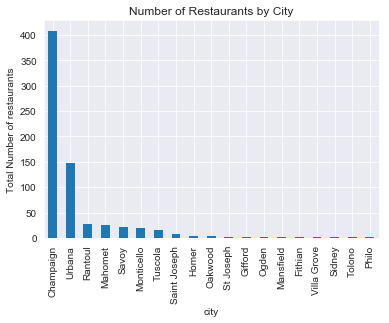

city
Champaign       408
Urbana          148
Rantoul          28
Mahomet          25
Savoy            22
Monticello       19
Tuscola          16
Saint Joseph      8
Homer             3
Oakwood           3
St Joseph         2
Gifford           2
Ogden             2
Mansfield         2
Fithian           1
Villa Grove       1
Sidney            1
Tolono            1
Philo             1
Name: restau_name, dtype: int64

In [90]:
# Number of reviews by city
restaus_by_city = restaurant_revsratscmntz.groupby(['city'])['restau_name'].nunique().sort_values(axis=0,ascending=False)
restaus_by_city.plot(title = 'Number of Restaurants by City',kind='bar',stacked=True)
plt.ylabel('Total Number of restaurants')
plt.show()
restaus_by_city

In [91]:
# Determine Restaurant with highest number of reviews

rest_revs=restaurants_revsratscmntz.groupby(['restau_name','city'])['user_restau_rating'].count().sort_values(axis=0,ascending=False)
rest_revs.head(10)

restau_name                                city     
"Black Dog Smoke & Ale House"              Urbana       745
"DESTIHL Restaurant & Brew Works"          Champaign    490
"Maize Mexican Grill"                      Champaign    471
"Papa Del's Pizza"                         Champaign    373
"Golden Harbor Authentic Chinese Cuisine"  Champaign    363
"Courier Cafe"                             Urbana       322
"Sakanaya Restaurant"                      Champaign    315
"Radio Maria"                              Champaign    292
"Seven Saints"                             Champaign    288
"Big Grove Tavern"                         Champaign    287
Name: user_restau_rating, dtype: int64

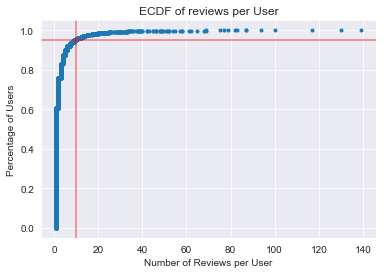

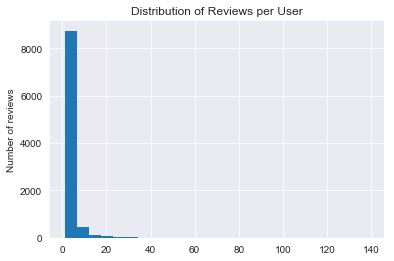

user_name
Nelson      139
Lisa        130
Mark        117
Ashley      100
Teej         94
Daniella     87
A            87
Alex         83
Jamie        82
Kent K.      79
Jay          77
Tim          75
Anne         69
Sarah        69
Melissa      68
Jessica      65
Natalie      62
Yum          61
Sherry       58
Seth         58
Name: user_restau_rating, dtype: int64

The median of the number of reviews per user is 1.0


count    9496.000000
mean        2.838880
std         5.840909
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       139.000000
Name: user_restau_rating, dtype: float64

In [92]:
# Number of reviews by user

num_rating=restaurants_revsratscmntz.groupby(['user_id', 'user_name'])['user_restau_rating'].count().sort_values(axis=0,ascending=False)



def ecdf(data):
    """Compute Empirical Cumulative Distribution Function (ECDF) for a 1D array of measurements."""
    # Number of data points
    n = len(data)
    
    # Data for the x-axis of the ecdf.
    x = np.sort(data)
    
    # Data for the y-axis of the ecdf
    y = np.arange(1, n+1)/n
    
    return x , y

# ecdf of number of ratings per cumtomer.
x,y = ecdf(num_rating)
num_bins = int(np.sqrt(len(num_rating))) # formular for determining bin size.
plt.plot(x,y,marker='.',linestyle='none')
plt.title('ECDF of reviews per User')
plt.xlabel('Number of Reviews per User')
plt.ylabel('Percentage of Users')
plt.axhline(0.95, color = 'r', alpha = 0.5)
plt.axvline(10, color = 'r', alpha = 0.5)
plt.show()

plt.hist(num_rating, bins =25)
plt.title('Distribution of Reviews per User')
plt.ylabel('Number of reviews')

plt.show()

num_rating.index= num_rating.index.droplevel()
print(num_rating.head(20))
print('\nThe median of the number of reviews per user is',num_rating.median())
num_rating.describe()

#### Weighted Rating

In order not to recommend a 5 star rated restaurant reviewed by one person over a 5 star restaurant rated by say 100 people, we use a weighted rating (score) which is not only based on the rating of the restaurant (restau_rating) but also the popularity of the restaurant (restau_review_count). which will be given the following IMDB formular:

 Weighted Rating: $$score = (\frac{v}{v+m} R)+ (\frac{m}{v+m}C)$$
 
 
 Where:
- v is the number of restaurant reviews;
- m is the minimum number of reviews required to be recommended;
- R is the average rating of the restaurant
- C is the mean rating across the whole report


In [93]:
# Considered a zero quantile to have restaurants with the fewest number of reviews
m = restaurants_revsratscmntz.restau_review_count.quantile(0.0)
m

3.0

In [94]:
# The average rating across all restaurants.
C = restaurants_revsratscmntz.user_restau_rating.mean()
C

3.6127812581087593

In [125]:

def weighted_rating(x, m=m, C=C):
    '''Function calculates the weighted rating based on the number of reviews a restaurant has and its average rating'''
    v = x.restau_review_count
    R = x.restau_rating 
    return (v/(v+m) * R) + (m/(m+v) * C)# Calculation based on the IMDB formula



In [126]:
# Adding a column with the weighted rating to the data set under a new column name 'score'.
restaurants_revsratscmntz['score'] = restaurants_revsratscmntz.apply(weighted_rating,axis=1)

In [127]:

print('\nTotal number of reviews on',len(restaurants_revsratscmntz.business_id.unique()),'restaurants or eateries across IL is',\
      len(restaurants_revsratscmntz),'provided by',\
      len(restaurants_revsratscmntz.user_id.unique()),'reviewers\n')

restaurants_revsratscmntz.pivot_table(['restau_review_count','score'], index='restau_name').sort_values(by='score',axis=0, ascending=False).head(20)


Total number of reviews on 763 restaurants or eateries across IL is 26977 provided by 9512 reviewers



,restau_review_count,score
restau_name,,
"""El Oasis""",77.0,4.947979
"""Old Time Meat & Deli Shoppe""",45.0,4.913299
"""Caribbean Grill Restaurant""",41.0,4.905417
"""Fernando's Food""",29.0,4.869948
"""Krannert Center for the Performing Arts""",27.0,4.861278
"""Prairie Fruits Farm & Creamery""",16.0,4.780965
"""Fresh International Market""",16.0,4.780965
"""Salad Meister""",13.0,4.739896
"""Wines At the Pines""",12.0,4.722556


In [98]:
# Dropping rows with all null values
restaurants_revsratscmntz.dropna(how='all',inplace=True)
restaurants_revsratscmntz.user_avg_stars.isnull().sum()

0

In [130]:
# The ratings matrix with Users ratings for every restaurant. 
ratings_mat = restaurants_revsratscmntz.pivot_table('user_restau_rating', index='business_id', columns='user_id')
print('The shape of the ratings matrix is:',ratings_mat.shape)
ratings_mat.head(10)

The shape of the ratings matrix is: (763, 9512)


user_id,-06IbFmaohdrg7kQKc3A4A,-0e6xyw_4zyg-2YtqSlS_g,-0xEqfbgJFmbXh53qSqEww,-3agoL-p87vZteiDzrz5og,-4GjoEvMHZlG8DQWy8xqtA,-5HYPAQFgtX4daBhmvO-wA,-5RiprVYwmC33pb6sX7PGg,-5WGH-41QNEVoHp6Wp53pg,-5hRD6Au5CXQqZGq1oPkEQ,-6DkJPEBQWJZm3FEWbNa_w,...,zxmVOQ7vzda-UliOuqZAlw,zxtl3pGOCMXjtYnSZaghPQ,zyEWeoMiTduGGaGU0i7jTw,zyF6zt18FWwJSPZjbnHJAg,zyVepjd-ZcNuc1tSvLeZYw,zyWJxFwO6KwpAMH_yK7BKw,zyzxWYBBWIrRdBkbwnnVrQ,zzBuXG7J0QMrIZeHq-JfSg,zzZ1HJGNhhI7GqhHIzlPhA,zzmtLn03VndGVKJPC_E2tw
business_id,,,,,,,,,,,,,,,,,,,,,
-05uZNVbb8DhFweTEOoDVg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2q4dnUw0gGJniGW2aPamQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5NXoZeGBdx3Bdk70tuyCw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5dd-RjojGVK9hjAMCXVZw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7PuYohz9dR80iGfVR_kLA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-865Ps6xb3h1LP67JcQ3mA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-A4suUjxa7gNaiUMDjO42g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-B1en4UZJzJEBiFjp1OJSQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Jhlh8Scjy669NdtCfKSSg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Model Validation:

To validate the model, we split the data using the `train_test_split` function from the `sklearn.model_selection library` into a training and test data set in a ratio 4:1 respectively. 

In [100]:
# Save the ratings matrix to a csv file. Also split the matrix into test and train data
restaurants_revsratscmntz.to_csv('restaurants_revsratscmnts_IL.csv')
restaurants_revsratscmntz_train, restaurants_revsratscmntz_test = train_test_split(restaurants_revsratscmntz, test_size=0.2, random_state = 0)

In [101]:
len(restaurants_revsratscmntz_train.user_avg_stars)

21581

In [102]:
len(restaurants_revsratscmntz_test.user_avg_stars)

5396

In [103]:
restaurants_revsratscmntz.user_avg_stars.isnull().sum()

0

In [104]:
cities = restaurants_revsratscmntz.city.unique()
cities

array(['Champaign', 'Urbana', 'Tuscola', 'Mahomet', 'Savoy', 'Rantoul',
       'Mansfield', 'Monticello', 'Philo', 'Homer', 'Saint Joseph',
       'Ogden', 'St Joseph', 'Tolono', 'Sidney', 'Fithian', 'Oakwood',
       'Gifford', 'Villa Grove'], dtype=object)

#### Collaborative-based recommendation

Pandas is used to build a collaborative filter that estimates ratings using a pearson correlation as the similarity metric that compares users. The performance of the recommendation is measured through a defined function called `evaluate` that makes use of the `mean_square_error` function from the `sklearn.metrics` library. These are all bundled in the class `RatingsReco`

In [105]:
# Function to compute Root Mean Squared Speed
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(mean_squared_error(y_pred, y_true)) 


def evaluate(func):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(restaurants_revsratscmntz_test.user_id, restaurants_revsratscmntz_test.business_id)
    estimated = np.array([func(u,i) for (u,i) in ids_to_estimate])
    real = restaurants_revsratscmntz_test.user_restau_rating.values
    return compute_rmse(estimated, real)

def pearson(prfl1, prfl2):
    """Take two pd.Series objects and return a pearson correlation."""
    profl1 = prfl1 - prfl1.mean()
    profl2 = prfl2 - prfl2.mean()
    return np.sum(profl1 * profl2) / np.sqrt(np.sum(profl1 ** 2) * np.sum(profl2 ** 2))


class RatingsReco:
    """ Collaborative filtering using a pearson similarity metric """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = restaurants_revsratscmntz.pivot_table('user_restau_rating', index='business_id', columns='user_id')

    def estimate(self, user_id, business_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = restaurants_revsratscmntz_train.user_id != user_id
        restau_condition = restaurants_revsratscmntz_train.business_id == business_id
        avg_mean = restaurants_revsratscmntz_train.user_avg_stars.loc[user_condition & restau_condition].mean()
        ratings_by_others = restaurants_revsratscmntz_train.loc[user_condition & restau_condition]
        if ratings_by_others.empty:
            return 3.0
        
        
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.user_restau_rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        

In [106]:
# Creating an instance of the class and calling the learn method of the class.
reco = RatingsReco()
%time reco.learn()

CPU times: user 330 ms, sys: 52.4 ms, total: 382 ms
Wall time: 241 ms


#### Model Evaluation:
The performance metric used is the `RMSE: Root Mean Square Error` which is called through the evaluate function. The RMSE is 1.05 which implies averagely the predicted ratings are approximately `1 star` off the actual ratings which is fairly good.

In [116]:
%time print ('RMSE for RatingsReco: %s' % evaluate(reco.estimate))

RMSE for RatingsReco: 1.0477057896764816
CPU times: user 13min 32s, sys: 7.63 s, total: 13min 40s
Wall time: 13min 56s


#### Display table with actual and predicted ratings

In [38]:
# Create a tuple of user_ids and business_ids.
usr_biz_ids = zip(restaurants_revsratscmntz.user_id,restaurants_revsratscmntz.business_id)

# Create an array of predicted ratings of user and restaurants
%time pred_rat = np.array([reco.estimate(usr_id,biz_id) for (usr_id,biz_id) in usr_biz_ids])

# Add the predicted values to the restaurants_revratescmntz under a column name 'pred_rating'
restaurants_revsratscmntz['pred_rating'] = np.around(pred_rat,0)

# Show user name, restaurant name user rating of the restaurant and the predicted rating of restaurant
restaurants_revsratscmntz[['user_name','restau_name','user_restau_rating','pred_rating']].head(10)


CPU times: user 1h 8min 58s, sys: 52.6 s, total: 1h 9min 51s
Wall time: 1h 10min 42s


,user_name,restau_name,user_restau_rating,pred_rating
0,Sheryl,"""Alexander's Steakhouse""",4,3.0
1,Michael,"""Alexander's Steakhouse""",2,2.0
2,Taffy,"""Alexander's Steakhouse""",5,4.0
3,Zewditu,"""Alexander's Steakhouse""",4,4.0
4,Jake,"""Alexander's Steakhouse""",5,3.0
5,Melissa,"""Alexander's Steakhouse""",2,3.0
6,Harry,"""Alexander's Steakhouse""",5,3.0
7,Herb,"""Alexander's Steakhouse""",2,2.0
8,Jay,"""Alexander's Steakhouse""",4,5.0
9,Chad,"""Alexander's Steakhouse""",5,3.0


#### Restaurant recommendation by city:

The `restau_recommend` function recommends to a user a list of restaurants in the cities of Illinois which have a predicted rating or `5 stars` to the specific user and have a high weighted score.

In [110]:
def restau_recommend(user, city):
    '''Function takes each city and recommends top restaurants which have 5 starts and have 
    high scores'''
    restau_rec = []

    for i in restaurants_revsratscmntz.business_id[restaurants_revsratscmntz.city==city].unique():
        if (reco.estimate(user,i) == 5.0):
            restau_info=(restaurants_revsratscmntz.user_name[restaurants_revsratscmntz.user_id==user].unique()[0],\
                         restaurants_revsratscmntz.city[restaurants_revsratscmntz.city==city].unique()[0],\
                         restaurants_revsratscmntz.restau_name[restaurants_revsratscmntz.business_id==i].unique()[0],\
                         restaurants_revsratscmntz.restau_rating[restaurants_revsratscmntz.business_id==i].unique()[0],\
                         float(round((reco.estimate(user,i)+restaurants_revsratscmntz.score[restaurants_revsratscmntz.business_id==i].unique()[0])/2)),\
                         round(restaurants_revsratscmntz.score[restaurants_revsratscmntz.business_id==i].unique()[0],2))
            
            restau_rec.append(restau_info)
    
    restau_rec = pd.DataFrame(restau_rec, columns=['USER NAME','CITY','RESTAURANT NAME', 'RESTAU RATING','PREDICTED RATING', 'SCORE']).sort_values(by=['SCORE','PREDICTED RATING'], ascending=False).reset_index(drop=True)
    recommended_restau = restau_rec[restau_rec['PREDICTED RATING'] == 5.0][['USER NAME','CITY','RESTAURANT NAME']]
    return recommended_restau

### Recommend Restaurants to 3 users:

The restau_recommend function is used to recommend restaurants to Amanda, J. and Mindy in the cities of Champaign,Mahomet and Urbana

In [134]:
restau_recommend('zyzxWYBBWIrRdBkbwnnVrQ','Champaign')

,USER NAME,CITY,RESTAURANT NAME
0,Amanda,Champaign,"""Fresh International Market"""
1,Amanda,Champaign,"""Aldi"""
2,Amanda,Champaign,"""Cafe Sababa"""
3,Amanda,Champaign,"""Wood N' Hog Barbecue"""
4,Amanda,Champaign,"""Leadbelly's"""
5,Amanda,Champaign,"""Edible Arrangements"""
6,Amanda,Champaign,"""Teamoji"""
7,Amanda,Champaign,"""Kung Fu Tea"""
8,Amanda,Champaign,"""Pie's the Limit"""
9,Amanda,Champaign,"""Binny's Beverage Depot"""


In [135]:
restau_recommend('-0xEqfbgJFmbXh53qSqEww', 'Champaign')

,USER NAME,CITY,RESTAURANT NAME
0,J.,Champaign,"""Aldi"""
1,J.,Champaign,"""Cafe Sababa"""
2,J.,Champaign,"""Leadbelly's"""
3,J.,Champaign,"""Edible Arrangements"""
4,J.,Champaign,"""Teamoji"""
5,J.,Champaign,"""Kung Fu Tea"""
6,J.,Champaign,"""Grovestone"""
7,J.,Champaign,"""Wedding Cakes by Rosie"""


In [136]:
restau_recommend('-3agoL-p87vZteiDzrz5og', 'Champaign')

,USER NAME,CITY,RESTAURANT NAME
0,Mindy,Champaign,"""Aldi"""
1,Mindy,Champaign,"""Cafe Sababa"""
2,Mindy,Champaign,"""Leadbelly's"""
3,Mindy,Champaign,"""Edible Arrangements"""
4,Mindy,Champaign,"""Teamoji"""
5,Mindy,Champaign,"""Kung Fu Tea"""
6,Mindy,Champaign,"""Grovestone"""
7,Mindy,Champaign,"""Wedding Cakes by Rosie"""


### Conclusion:

This recommendation system provides a user with a list of restaurants in a city that other users similar in taste to this specific user would recommend to him.

A specific case of 19 Illinois cities extracted from the yelp data set was used. This could be scaled to different cities nationally.

Such a system is useful in recommending restaurants to a yelp user when he gets into a new city not based on distance but on its popularity and rating by other users similar to this user.